# Data processing 

## Imports

In [1]:
import numpy as np
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from torchtext.vocab import GloVe

## Parameters

In [2]:
max_words = 20
embed_len = 300
batch_size = 64

## Load dataset

In [3]:
with open('intents.json', 'r') as f:
    intents = json.load(f)

In [4]:
tags = []
xy = []

# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:
        # add to xy pair
        xy.append((pattern, tag))

In [5]:
# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    X_train.append(pattern_sentence)

    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape, X_train[:3])
print(y_train.shape, y_train[:3])

(74,) ['Hi' 'Hey' 'How are you']
(74,) [0 0 0]


In [6]:
class Sequences(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train
        
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]
    
    def __len__(self):
        return self.n_samples

# Model definition

In [7]:
num_epochs = 1000
learning_rate = 1e-3
input_size = max_words*embed_len
output_size = len(tags)

In [8]:
class RNN(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, 128)
        self.drop = nn.Dropout(p=0.5)
        self.fc = torch.nn.Linear(128, output_dim)
        

    def forward(self, text):        
        output, _ = self.lstm(text)        
        output = self.drop(output)
        output = self.fc(output)
        output = torch.squeeze(output, 1)
        
        return output


# Training

In [9]:
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")
glove = GloVe(name='840B', dim=300)

In [10]:
def vectorize_batch(batch):
    X, Y = list(zip(*batch))
    X = [tokenizer(x) for x in X]
    X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]
    X_tensor = torch.zeros(len(batch), max_words, embed_len)
    for i, tokens in enumerate(X):
        X_tensor[i] = glove.get_vecs_by_tokens(tokens)

    return X_tensor.reshape(len(batch), -1), torch.tensor(Y) ## Subtracted 1 from labels to bring in range [0,1,2,3] from [1,2,3,4]

In [11]:
dataset = Sequences()

## Split data
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, collate_fn=vectorize_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=False, collate_fn=vectorize_batch)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN(input_size, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    correct = 0
    correct_test = 0

    # Train loop
    for words, labels in train_loader:
        words = words.to(dtype=torch.float).to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, dim=1)
        correct += torch.sum(predicted == labels)
    
    train_accuracy = (100 * correct / len(train_dataset)).to('cpu')
    train_losses.append(loss.item())
    train_accs.append(train_accuracy)
    
    # Test loop
    with torch.no_grad():
        for words, labels in test_loader:
            words = words.to(dtype=torch.float).to(device)
            labels = labels.to(dtype=torch.long).to(device)

            # Forward pass
            outputs = model(words)
            test_loss = criterion(outputs, labels)

            _, predicted_test = torch.max(outputs, dim=1)
            correct_test += torch.sum(predicted_test == labels)
    
    
    test_accuracy = (100 * correct_test / len(train_dataset)).to('cpu')
    test_losses.append(test_loss.item())
    test_accs.append(test_accuracy)
    
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}]')       
        print (f'(Train) Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')
        print (f'(Test) Loss: {test_loss.item():.4f}, Accuracy: {test_accuracy:.4f}')
        print('')

Epoch [100/1000]
(Train) Loss: 0.0231, Accuracy: 100.0000
(Test) Loss: 1.6374, Accuracy: 11.8644

Epoch [200/1000]
(Train) Loss: 0.0081, Accuracy: 100.0000
(Test) Loss: 1.4498, Accuracy: 11.8644

Epoch [300/1000]
(Train) Loss: 0.0049, Accuracy: 100.0000
(Test) Loss: 1.7212, Accuracy: 11.8644

Epoch [400/1000]
(Train) Loss: 0.0018, Accuracy: 100.0000
(Test) Loss: 1.7279, Accuracy: 11.8644

Epoch [500/1000]
(Train) Loss: 0.0017, Accuracy: 100.0000
(Test) Loss: 1.6721, Accuracy: 11.8644

Epoch [600/1000]
(Train) Loss: 0.0020, Accuracy: 100.0000
(Test) Loss: 1.7693, Accuracy: 11.8644

Epoch [700/1000]
(Train) Loss: 0.0011, Accuracy: 100.0000
(Test) Loss: 1.9098, Accuracy: 11.8644

Epoch [800/1000]
(Train) Loss: 0.0010, Accuracy: 100.0000
(Test) Loss: 2.1649, Accuracy: 10.1695

Epoch [900/1000]
(Train) Loss: 0.0005, Accuracy: 100.0000
(Test) Loss: 2.0190, Accuracy: 10.1695

Epoch [1000/1000]
(Train) Loss: 0.0007, Accuracy: 100.0000
(Test) Loss: 2.1127, Accuracy: 11.8644



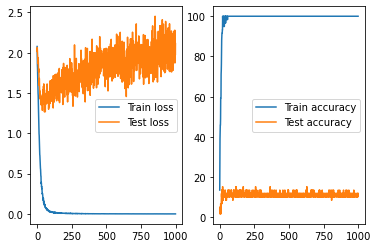

In [13]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train accuracy')
plt.plot(test_accs, label='Test accuracy')
plt.legend()

plt.show()

# Save model

In [15]:
data = {
"model_state": model.state_dict(),
"input_size": input_size,
"output_size": output_size,
"tags": tags
}

FILE = "model.pth"
torch.save(data, FILE)